This is the notebook for basic CNN model

In [5]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [6]:
import os
project_data_path='/content/drive/My Drive/Colab Notebooks/project'
os.chdir(project_data_path)
print(os.getcwd())

/content/drive/My Drive/Colab Notebooks/project


## (i) Importing the necessary packages

In [7]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt

## (ii)(a) Loading and visualizing the dataset 

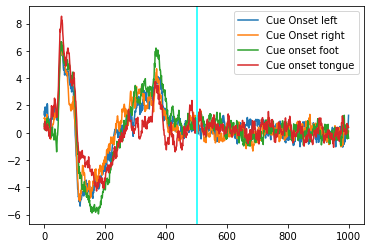

In [8]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

y_test_original=y_test#store original test label

## Visualizing the data

ch_data = X_train_valid[:,8,:] # extracts the 9th channel from the data


class_0_ind = np.where(y_train_valid == 0) # finds the indices where the label is 0
ch_data_class_0 = ch_data[class_0_ind] # finds the data where label is 0
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0) # finds the average representation of the 9th channel when label is 0


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])





## (ii)(b) Preprocessing the dataset

![EEG_prep.png](attachment:EEG_prep.png)

In [9]:
def data_prep(X,y,sub_sample,average,noise,trim_time=500):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:trim_time]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)


Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)


## (ii)(c) Preparing the training, validation, and test datasets

In [10]:
## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


## Preprocessing the dataset
x_train,y_train = data_prep(X_train,y_train,2,2,True)
x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)


print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',y_test_prep.shape)

print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)



# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)





    



Shape of X after trimming: (1740, 22, 500)
Shape of X after maxpooling: (1740, 22, 250)
Shape of X after averaging+noise and concatenating: (3480, 22, 250)
Shape of X after subsampling and concatenating: (6960, 22, 250)
Shape of X after trimming: (375, 22, 500)
Shape of X after maxpooling: (375, 22, 250)
Shape of X after averaging+noise and concatenating: (750, 22, 250)
Shape of X after subsampling and concatenating: (1500, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
Shape of testing set: (1772, 22, 250)
Shape of testing labels: (1772,)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of training labels after categorical conversion: (6960, 4)
Shape of validation labels after categorical conversion: (15

## (iii)(CNN) Defining the architecture of a basic CNN model

In [11]:
# Building the CNN model using sequential class
def Basic_CNN(trim_time=500):
  basic_cnn_model = Sequential()

# Conv block 1 conv+maxpooling+batchnorm 
  basic_cnn_model.add(Conv2D(filters=10, kernel_size=(10,1), padding='same', activation='elu', input_shape=(int(trim_time/2),1,22)))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(0.5))

# Conv block 2
  basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu'))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(0.5))


# Conv Block 3
  basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(0.5))

# Conv Block 4
  basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(0.5))

 # Conv Block 5
  basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(0.5))




# FC layer + Softmax activation
  basic_cnn_model.add(Flatten()) # Flattens the input
  basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
  basic_cnn_model.summary()
  return basic_cnn_model

#basic_cnn_model.summary()

## (iv)(CNN) Defining the hyperparameters of the basic CNN model

In [ ]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules

In [ ]:
# Model parameters
learning_rate = 1e-4
epochs=100
cnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)



## (v)(CNN) Compiling, training and validating the model

In [ ]:
# Compiling the model
basic_cnn_model=Basic_CNN()
basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
basic_cnn_model_results = basic_cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True) #how to store the results? 


Epoch 1/100
109/109 [==============================] - 5s 12ms/step - loss: 2.0186 - accuracy: 0.2881 - val_loss: 1.3432 - val_accuracy: 0.3593
Epoch 2/100
109/109 [==============================] - 2s 19ms/step - loss: 1.6113 - accuracy: 0.3164 - val_loss: 1.4789 - val_accuracy: 0.3193
Epoch 3/100
109/109 [==============================] - 1s 12ms/step - loss: 1.4488 - accuracy: 0.3534 - val_loss: 1.2993 - val_accuracy: 0.3393
Epoch 4/100
109/109 [==============================] - 1s 11ms/step - loss: 1.3499 - accuracy: 0.3876 - val_loss: 1.3111 - val_accuracy: 0.3740
Epoch 5/100
109/109 [==============================] - 1s 9ms/step - loss: 1.2842 - accuracy: 0.4221 - val_loss: 1.2596 - val_accuracy: 0.3933
Epoch 6/100
109/109 [==============================] - 1s 9ms/step - loss: 1.2376 - accuracy: 0.4435 - val_loss: 1.2537 - val_accuracy: 0.4100
Epoch 7/100
109/109 [==============================] - 1s 9ms/step - loss: 1.1970 - accuracy: 0.4728 - val_loss: 1.2445 - val_accuracy: 0.

## (vi)(CNN) Visualizing the accuracy and loss trajectory

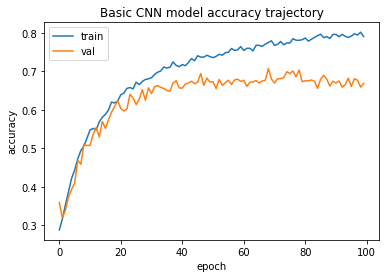

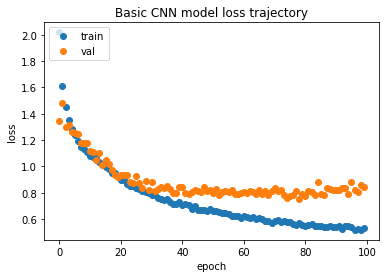

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## (vii)(CNN) Testing the performance of the basic CNN model on the held out test set

In [ ]:
## Testing the basic CNN model

cnn_score = basic_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.70033860206604


## The following section is used to answer EEG questions

##(i)Train on subject 1. Does it help to train across all subject?

In [28]:
def process_data(X_train_valid,y_train_valid):   
    x_train_valid_p, y_train_valid_p = data_prep(X_train_valid, y_train_valid, 2, 2, True)
    y_train_valid_p = to_categorical(y_train_valid_p, 4)
    x_train_valid_p = x_train_valid_p.reshape(x_train_valid_p.shape[0], x_train_valid_p.shape[1], x_train_valid_p.shape[2], 1)
    x_train_valid_p = np.swapaxes(x_train_valid_p, 1,3)
    x_train_valid_p = np.swapaxes(x_train_valid_p, 1,2)
    return x_train_valid_p, y_train_valid_p

In [29]:
#train:subject1
#test:subject 1-9
index_train=np.where(person_train_valid==0)
#index_train=person_train_valid.find(0)
#index_test=np.where_test==0)
X_train_subject1=X_train_valid[index_train[0]]
y_train_subject1=y_train_valid[index_train[0]]
X_test_subject=[]
y_test_subject=[]
X_train_subject_p,y_train_subject_p=process_data(X_train_subject1,y_train_subject1)
for i in range(9):
    index_test=np.where(person_test==i)
    X_test_subject_p,y_test_subject_p= process_data(X_test[index_test[0]],y_test_original[index_test[0]])
    X_test_subject.append(X_test_subject_p)
    y_test_subject.append(y_test_subject_p)

Shape of X after trimming: (237, 22, 500)
Shape of X after maxpooling: (237, 22, 250)
Shape of X after averaging+noise and concatenating: (474, 22, 250)
Shape of X after subsampling and concatenating: (948, 22, 250)
Shape of X after trimming: (50, 22, 500)
Shape of X after maxpooling: (50, 22, 250)
Shape of X after averaging+noise and concatenating: (100, 22, 250)
Shape of X after subsampling and concatenating: (200, 22, 250)
Shape of X after trimming: (50, 22, 500)
Shape of X after maxpooling: (50, 22, 250)
Shape of X after averaging+noise and concatenating: (100, 22, 250)
Shape of X after subsampling and concatenating: (200, 22, 250)
Shape of X after trimming: (50, 22, 500)
Shape of X after maxpooling: (50, 22, 250)
Shape of X after averaging+noise and concatenating: (100, 22, 250)
Shape of X after subsampling and concatenating: (200, 22, 250)
Shape of X after trimming: (50, 22, 500)
Shape of X after maxpooling: (50, 22, 250)
Shape of X after averaging+noise and concatenating: (100, 

In [ ]:
#define hyperparameters and compile the model
learning_rate = 1e-4
epochs=100
cnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Compiling the model
basic_cnn_model1=Basic_CNN()#the model for subject 1
basic_cnn_model1.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model

basic_cnn_model_results1 = basic_cnn_model1.fit(X_train_subject_p,
             y_train_subject_p,
             batch_size=64,
             epochs=epochs,verbose=True)




Epoch 1/100
15/15 [==============================] - 2s 67ms/step - loss: 2.1866 - accuracy: 0.3112
Epoch 2/100
15/15 [==============================] - 1s 77ms/step - loss: 1.9910 - accuracy: 0.3376
Epoch 3/100
15/15 [==============================] - 2s 105ms/step - loss: 1.7866 - accuracy: 0.3787
Epoch 4/100
15/15 [==============================] - 1s 96ms/step - loss: 1.5617 - accuracy: 0.4283
Epoch 5/100
15/15 [==============================] - 1s 66ms/step - loss: 1.5335 - accuracy: 0.4156
Epoch 6/100
15/15 [==============================] - 1s 66ms/step - loss: 1.3400 - accuracy: 0.4800
Epoch 7/100
15/15 [==============================] - 1s 65ms/step - loss: 1.2471 - accuracy: 0.5095
Epoch 8/100
15/15 [==============================] - 1s 65ms/step - loss: 1.1558 - accuracy: 0.5527
Epoch 9/100
15/15 [==============================] - 1s 64ms/step - loss: 1.0425 - accuracy: 0.5939
Epoch 10/100
15/15 [==============================] - 1s 65ms/step - loss: 0.9777 - accuracy: 0.596

In [ ]:
#test on testdata
cnn_score_subject1=[]
for i in range(9): 
  cnn_score = basic_cnn_model1.evaluate(X_test_subject[i], y_test_subject[i], verbose=0)#test using data from differen subject
  cnn_score_subject1.append(cnn_score[1])
  print('Test accuracy of the basic CNN model:',cnn_score[1])



Test accuracy of the basic CNN model: 0.6800000071525574
Test accuracy of the basic CNN model: 0.3799999952316284
Test accuracy of the basic CNN model: 0.6150000095367432
Test accuracy of the basic CNN model: 0.27000001072883606
Test accuracy of the basic CNN model: 0.31382977962493896
Test accuracy of the basic CNN model: 0.2908163368701935
Test accuracy of the basic CNN model: 0.5649999976158142
Test accuracy of the basic CNN model: 0.4399999976158142
Test accuracy of the basic CNN model: 0.36702126264572144


In [11]:
#basic_cnn_model=Basic_CNN()
# Model parameters
#learning_rate = 1e-3
#epochs=100
#cnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Compiling the model
#basic_cnn_model.compile(loss='categorical_crossentropy',
                 #optimizer=cnn_optimizer,
                 #metrics=['accuracy'])

# Training and validating the model
#x_train_valid=np.vstack((x_train,x_valid))
#y_train_valid=np.vstack((y_train,y_valid))
#basic_cnn_model_results = basic_cnn_model.fit(x_train_valid,
             #y_train_valid,
             #batch_size=64,
             #epochs=epochs,verbose=True)


In [ ]:
#use the model in section 1 to test
cnn_score_total=[]
for i in range(9): 
  cnn_score = basic_cnn_model.evaluate(X_test_subject[i], y_test_subject[i], verbose=0)
  cnn_score_total.append(cnn_score[1])
  print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.5450000166893005
Test accuracy of the basic CNN model: 0.5350000262260437
Test accuracy of the basic CNN model: 0.8550000190734863
Test accuracy of the basic CNN model: 0.6499999761581421
Test accuracy of the basic CNN model: 0.7765957713127136
Test accuracy of the basic CNN model: 0.7193877696990967
Test accuracy of the basic CNN model: 0.75
Test accuracy of the basic CNN model: 0.675000011920929
Test accuracy of the basic CNN model: 0.75


##(ii)Evaluate the classification accuracy as a function of time

In [13]:
#data processing for segmenting sequence
#trim_time can be adjusted to acquire different time length
#250 500 750 1000

def process_data_new(X_train_valid,y_train_valid,trim_time):   
    x_train_valid_p, y_train_valid_p = data_prep(X_train_valid, y_train_valid, 2, 2, True,trim_time)
    y_train_valid_p = to_categorical(y_train_valid_p, 4)
    x_train_valid_p = x_train_valid_p.reshape(x_train_valid_p.shape[0], x_train_valid_p.shape[1], x_train_valid_p.shape[2], 1)
    x_train_valid_p = np.swapaxes(x_train_valid_p, 1,3)
    x_train_valid_p = np.swapaxes(x_train_valid_p, 1,2)
    return x_train_valid_p,y_train_valid_p 



In [38]:
time_sequence=[250,500,750,1000]
CNN_time_accuracy=[]
for trim_time in time_sequence:
    X_train_sequence,y_train_sequence=process_data_new(X_train_valid,y_train_valid,trim_time=trim_time)
    X_test_sequence,y_test_sequence=process_data_new(X_test,y_test_original,trim_time=trim_time)
    print('shape of train sequence',np.shape(X_train_sequence))
    print('shape of train sequence label',np.shape(y_train_sequence))
    print('shape of test sequence',np.shape(X_test_sequence))
    print('shape of test sequence label',np.shape(y_test_sequence))
    learning_rate = 1e-4
    epochs=100
    cnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    basic_cnn_model_new=Basic_CNN(trim_time=trim_time)
    basic_cnn_model_new.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
    new_cnn_model_results = basic_cnn_model_new.fit(X_train_sequence,y_train_sequence,
             batch_size=64,
             epochs=epochs,verbose=True)
    cnn_score= basic_cnn_model_new.evaluate(X_test_sequence,y_test_sequence,verbose=0)
    CNN_time_accuracy.append(cnn_score[1])
    print('Test accuracy of the basic CNN model:',cnn_score[1])

Shape of X after trimming: (2115, 22, 200)
Shape of X after maxpooling: (2115, 22, 100)
Shape of X after averaging+noise and concatenating: (4230, 22, 100)
Shape of X after subsampling and concatenating: (8460, 22, 100)
Shape of X after trimming: (443, 22, 200)
Shape of X after maxpooling: (443, 22, 100)
Shape of X after averaging+noise and concatenating: (886, 22, 100)
Shape of X after subsampling and concatenating: (1772, 22, 100)
shape of train sequence (8460, 100, 1, 22)
shape of train sequence label (8460, 4)
shape of test sequence (1772, 100, 1, 22)
shape of test sequence label (1772, 4)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 100, 1, 10)        2210      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 34, 1, 10)        0         
 g2D)                                          

In [ ]:
trim_time=500
X_train_sequence,y_train_sequence=process_data_new(X_train_valid,y_train_valid,trim_time=trim_time)
X_test_sequence,y_test_sequence=process_data_new(X_test,y_test_original,trim_time=trim_time)
  
learning_rate = 1e-3
epochs=100
cnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
basic_cnn_model_new=Basic_CNN(trim_time=trim_time)
basic_cnn_model_new.compile(loss='categorical_crossentropy',
                optimizer=cnn_optimizer,
                metrics=['accuracy'])
new_cnn_model_results = basic_cnn_model_new.fit(X_train_sequence,y_train_sequence,
             batch_size=64,
             epochs=epochs,verbose=True)
cnn_score= basic_cnn_model_new.evaluate(X_test_sequence,y_test_sequence,verbose=0)


Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 250, 1, 10)        2210      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 84, 1, 10)        0         
 g2D)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 84, 1, 10)        40        
 chNormalizat

In [39]:
CNN_time_accuracy

[0.45203161239624023,
 0.5942437648773193,
 0.6156885027885437,
 0.6202031373977661]